In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objects as go

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

savepath = "results/P1Q1/"

In [123]:
mat = loadmat('HatsopoulosReachTask.mat', squeeze_me=True, struct_as_record=False)

firingRate  = np.asarray(mat['firingRate'])
direction   = np.asarray(mat['direction']).ravel().astype(int)
brainRegion = np.array(mat['brainRegion']).ravel()

numNeurons, numTimebins, numTrials = firingRate.shape
print(f"Neurons: {numNeurons}, Timebins: {numTimebins}, Trials: {numTrials}")

neuron_time_direction = np.zeros((numNeurons, numTimebins, 8), dtype=float)
for d in range(1, 9):
    dir_pos = np.where(direction == d)[0]
    if dir_pos.size > 0:
        neuron_time_direction[:, :, d - 1] = firingRate[:, :, dir_pos].mean(axis=2)
    else:
        pass

Neurons: 143, Timebins: 30, Trials: 158


In [124]:
neuronbytime8 = neuron_time_direction.reshape(numNeurons, numTimebins * 8)
neuronbytime8 = neuronbytime8 - neuronbytime8.mean(axis=1, keepdims=True) 

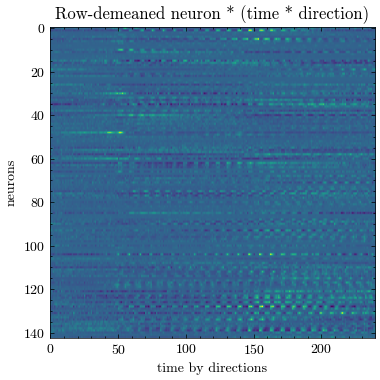

In [125]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(neuronbytime8, aspect='auto')
ax.set_xlabel('time by directions')
ax.set_ylabel('neurons')
ax.set_title('Row-demeaned neuron * (time * direction)')
fig.tight_layout()
fig.savefig(savepath + "neuronbytime8.png", dpi=300)

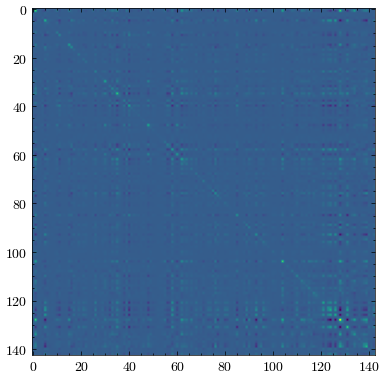

In [126]:
n_samples = neuronbytime8.shape[1]
cov_matrix = (neuronbytime8 @ neuronbytime8.T) / n_samples

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cov_matrix, aspect='auto')
fig.tight_layout()
fig.savefig(savepath + "cov_matrix.png", dpi=300)

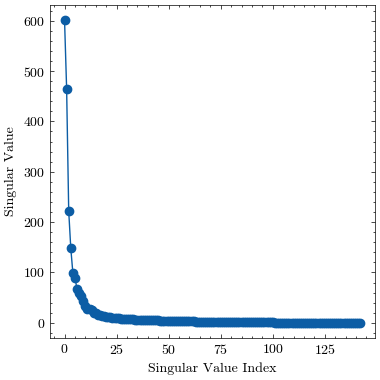

In [127]:
uu, s_vals, vvT = np.linalg.svd(cov_matrix, full_matrices=False)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(s_vals, marker='o')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value')
fig.tight_layout()
fig.savefig(savepath + "singular_values.png", dpi=1000)

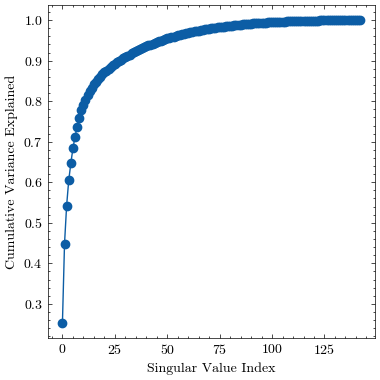

In [128]:
var_scale = np.cumsum(s_vals) / np.sum(s_vals)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(var_scale, marker='o')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Cumulative Variance Explained') 
fig.tight_layout()
fig.savefig(savepath + "cumulative_variance.png", dpi=1000)

In [129]:
cutoff = int(np.searchsorted(var_scale, 0.9) + 1)
print('cutoff (90% EV):', cutoff)

cutoff (90% EV): 29


In [130]:
PCs = uu[:, :3]  
projec = PCs.T @ neuronbytime8  
low_d_trajectory = projec.reshape(3, numTimebins, 8)
colors = plt.cm.jet(np.linspace(0, 1, 8))

In [151]:
T = low_d_trajectory.shape[1]
fig = go.Figure()

for ii in range(8):
    fig.add_trace(go.Scatter3d(
        x=low_d_trajectory[0, :, ii],
        y=low_d_trajectory[1, :, ii],
        z=low_d_trajectory[2, :, ii],
        mode="lines",
        name=f"Dir {ii+1}",
        line=dict(width=4),
        customdata=np.arange(T),  # to show time index on hover
        hovertemplate="t=%{customdata}<extra>%{fullData.name}</extra>",
    ))

fig.update_layout(
    title="3D trajectories by direction (PC space)",
    width=600,   
    height=400,  
    margin=dict(l=50, r=50, t=70, b=50),
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
        aspectmode="cube"  
    )
)
fig.show()

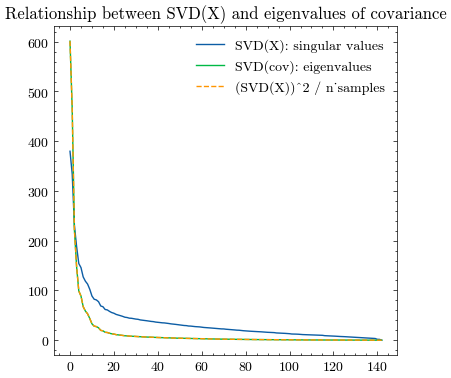

In [152]:
X = neuronbytime8.copy()
U_x, s_x, Vt_x = np.linalg.svd(X, full_matrices=False)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(s_x, label='SVD(X): singular values')
ax.plot(s_vals, label='SVD(cov): eigenvalues')
ax.plot((s_x**2) / n_samples, '--', label='(SVD(X))^2 / n_samples')
ax.legend()
ax.set_title('Relationship between SVD(X) and eigenvalues of covariance')
fig.tight_layout()
fig.savefig(savepath + "svd_vs_eigenvalues.png", dpi=1000)

In [ ]:
proj_svd = U_x[:, :3].T @ X
low_d_trajectory_svd = proj_svd.reshape(3, numTimebins, 8)

T = low_d_trajectory_svd.shape[1]
fig = go.Figure()

for ii in range(8):
    fig.add_trace(go.Scatter3d(
        x=low_d_trajectory_svd[0, :, ii],
        y=low_d_trajectory_svd[1, :, ii],
        z=low_d_trajectory_svd[2, :, ii],
        mode="lines",
        name=f"Dir {ii+1}",
        line=dict(width=4),
        customdata=np.arange(T),  # to show time index on hover
        hovertemplate="t=%{customdata}<extra>%{fullData.name}</extra>",
    ))

fig.update_layout(
    title="3D trajectories by direction (PC space)",
    width=600,   
    height=400,  
    margin=dict(l=50, r=50, t=70, b=50),
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
        aspectmode="cube"  
    )
)
fig.show()

In [154]:
region_name = 'MI'
region_id = np.where(np.array([str(br) == region_name for br in brainRegion]))[0]
time_bin_idx = 14 if numTimebins > 14 else (numTimebins // 2)

# what if only one area and one time bin? 
# feature_matrix = firingRate[region_id, slice(time_bin_idx, time_bin_idx + 1), :]
# feature_matrix = feature_matrix.reshape(feature_matrix.shape[0] * feature_matrix.shape[1], -1).T

# take everything into consideration
feature_matrix = firingRate.reshape(numNeurons * numTimebins, numTrials).T

print(f"feature_matrix: {feature_matrix.shape}")

# reach_binary = (direction > 4).astype(int)
# reach_binary = np.isin(direction, (3, 4, 7, 8)).astype(int)
# reach_binary = np.isin(direction, (1, 3, 5, 7)).astype(int)
reach_binary = np.isin(direction, (1, 2, 6, 7)).astype(int)
print(f"reach_binary: {reach_binary.shape}")

n_repeats = 50
n_splits = 5
all_cvs = np.zeros(n_repeats)

clf = LogisticRegression(max_iter=10000, solver='liblinear')  # logistic regression

for nn in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=nn)
    scores = cross_val_score(clf, feature_matrix, reach_binary, cv=skf, scoring='accuracy')
    all_cvs[nn] = scores.mean() 

feature_matrix: (158, 4290)
reach_binary: (158,)


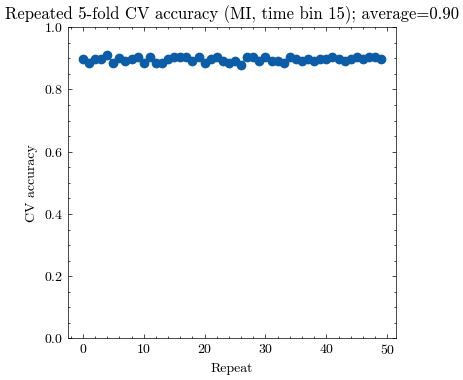

In [156]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(all_cvs, marker='o')
ax.set_ylim(0, 1)
ax.set_xlabel('Repeat')
ax.set_ylabel('CV accuracy')
ax.set_title(f'Repeated {n_splits}-fold CV accuracy ({region_name}, time bin {time_bin_idx+1}); average={all_cvs.mean():.2f}')
fig.tight_layout()
fig.savefig(savepath + f"cv_accuracy.png", dpi=300)